### aim: calculate top 5 percent windspeeds as an area-wide mean

### date: 

In [72]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [73]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [74]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [76]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([365, 149, 182])

for i in range(0,365):
    csize_broad[i,:] = tmesh['csize']

In [77]:
# hist_ukesm_winds = ukesm_wind.wspd.isel(y=slice(0,50)) #.weighted(tmesh.csize.isel(y=slice(0,50)))
# hist_ukesm_winds

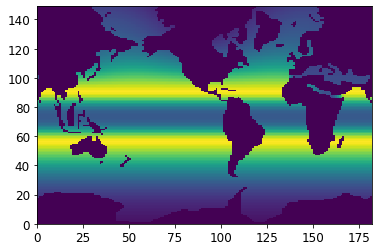

In [78]:
w2 = xr.open_dataset('//gpfs/data/greenocean/software/runs/TOM12_TJ_1ASA/ORCA2_1m_19900101_19901231_ptrc_T.nc')

tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

csize_broad = np.zeros([365, 149, 182])

for i in range(0,365):
    csize_broad[i,:] = tmesh['csize']

plt.pcolormesh(tmesh['csize'])

In [79]:
tmesh['nav_lat'][0:50,0]

<xarray.DataArray 'nav_lat' (y: 50)>
array([-78.19058 , -77.7742  , -77.34337 , -76.89761 , -76.43644 , -75.95934 ,
       -75.46582 , -74.95534 , -74.42735 , -73.88131 , -73.31665 , -72.73279 ,
       -72.129135, -71.5051  , -70.86005 , -70.193375, -69.50445 , -68.792625,
       -68.05725 , -67.29768 , -66.51326 , -65.703316, -64.867195, -64.00423 ,
       -63.113754, -62.195126, -61.247692, -60.27082 , -59.263885, -58.226284,
       -57.15743 , -56.05677 , -54.923775, -53.75795 , -52.558838, -51.326035,
       -50.059177, -48.757957, -47.422142, -46.051548, -44.646076, -43.20571 ,
       -41.73051 , -40.220642, -38.67636 , -37.09803 , -35.48612 , -33.84122 ,
       -32.16404 , -30.455408], dtype=float32)
Dimensions without coordinates: y

In [80]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [81]:
tw = np.array([3,4,5,2])
q = np.array([0,30000000,1,0.1])
weighted_quantile(tw, 0.95, sample_weight=q)

4.900000032999999

In [82]:
boundary_so = 37

def get_wind_extremes_and_maps_s50(yr, product = 'ukesm', verbose = False):
    
    boundary_so = 37
    tdir = '/gpfs/data/greenocean/software/resources/winds_gooddates/'
    print(f'{yr}, {product}')
    print(f'{yr}, {product}')
    if product == 'ukesm':
        taux = xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/scen_1A/MetOffice_taux_y{yr}.nc', decode_times=False)
        tauy =  xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/scen_1A/MetOffice_tauy_y{yr}.nc', decode_times=False)
    elif product == 'era5':
        if ((yr >=1959) & (yr < 1980)):
            taux = xr.open_dataset(f'{tdir}/ERA5_v202303_taux_{yr}_daily.nc', decode_times=False)
            tauy =   xr.open_dataset(f'{tdir}/ERA5_v202303_tauy_{yr}_daily.nc', decode_times=False)
            print('in weird time')
        else:
            taux = xr.open_dataset(f'{tdir}/ERA5_v2022_taux_{yr}_daily.nc', decode_times=False)
            tauy =   xr.open_dataset(f'{tdir}/ERA5_v2022_tauy_{yr}_daily.nc', decode_times=False)
            print('in non-weird time (ie no reanalysis 1959-1979)')            
    else:
        print('gonewrong')
        taux = 3
        tauy = 3

    # get windspeed 
    taux_v = taux['uflx'][:]
    tauy_v = tauy['vflx'][:]
    taux['wspd'] = np.sqrt(taux_v**2 + tauy_v**2)
    
    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left') 
    if product == 'ukesm':
        times = times[~((times.month == 2) & (times.day == 29))] #exclude leap years for ukesm
    taux['time_counter'] = times

    seas = ['DJF','MAM', 'JJA', 'SON']

    seasmean_map = np.zeros([4,boundary_so,182])
    seasmean = np.zeros(4)
    seas95 = np.zeros(4)
    seasextrema = np.zeros(4)
    
    for i in range(0,len(seas)):
        tseas = seas[i]
        twspd = taux.wspd.sel(time_counter=taux['time_counter.season']==tseas).values

        dis = (np.shape(twspd)[0]) #days in season
        weightedmean = np.ma.average(twspd[:,0:boundary_so,:], weights = csize_broad[0:dis,0:boundary_so,:])
        seasmean[i] = weightedmean
        #south of 30
        perc95 = weighted_quantile(np.ravel(twspd[:,0:boundary_so,:]), 0.95, sample_weight=np.ravel(csize_broad[0:dis,0:boundary_so,:]))
        seas95[i] = perc95
        
        extrema = twspd[twspd > perc95]
        meanextreme = np.nanmean(extrema)
        seasextrema[i] = meanextreme
        
        if verbose:
            print(f'{tseas}, mean wind {weightedmean}, 95th percentile winds: {perc95}, mean of top 5%: {meanextreme}')

        seasmean_map[i,:,:] = np.nanmean(twspd[:,0:boundary_so,:], axis = 0)
            
    return seasmean_map, seasmean, seas95, seasextrema
    
# yr = 1951
# seasmean_map, seasmean, seas95, seasextrema = get_wind_extremes_and_maps(yr, product = 'era', verbose = True)
# #yr = 2023
# seasmean_map, seasmean, seas95, seasextrema = get_wind_extremes_and_maps(yr, product = 'ukesm', verbose = True)

#1950-2020
#array = np.arange(1,9,1)
# pickle.dump(array, open("examplepickle.pkl", 'wb'))
# tpickle = pickle.load(open('./examplepickle.pkl', 'rb'))
# print(tpickle)

seasmean_map_ts_ukesm_s50 = np.zeros([2020-1950,4,boundary_so,182])
seasmean_ts_ukesm_s50 = np.zeros([2020-1950,4])
seas95_ts_ukesm_s50 = np.zeros([2020-1950,4])
seasextrema_ts_ukesm_s50 = np.zeros([2020-1950,4])

seasmean_map_ts_era_s50 = np.zeros([2020-1950,4,boundary_so,182])
seasmean_ts_era_s50 = np.zeros([2020-1950,4])
seas95_ts_era_s50 = np.zeros([2020-1950,4])
seasextrema_ts_era_s50 = np.zeros([2020-1950,4])

for yr in range(1950,2020):
    seasmean_map_ts_era_s50[yr-1950,:,:,:], seasmean_ts_era_s50[yr-1950,:], seas95_ts_era_s50[yr-1950,:], seasextrema_ts_era_s50[yr-1950,:] = \
        get_wind_extremes_and_maps_s50(yr, product = 'era5', verbose = False)
    seasmean_map_ts_ukesm_s50[yr-1950,:,:,:], seasmean_ts_ukesm_s50[yr-1950,:], seas95_ts_ukesm_s50[yr-1950,:], seasextrema_ts_ukesm_s50[yr-1950,:] = \
        get_wind_extremes_and_maps_s50(yr, product = 'ukesm', verbose = False)
    # seasmean_map_ts_era5[yr-1950,:,:,:] = seasmean_map
    # seasmean_map, seasmean, seas95, seasextrema = get_wind_extremes_and_maps(yr, product = 'ukesm', verbose = True)

1950, era5
1950, era5
in non-weird time (ie no reanalysis 1959-1979)
1950, ukesm
1950, ukesm
1951, era5
1951, era5
in non-weird time (ie no reanalysis 1959-1979)
1951, ukesm
1951, ukesm
1952, era5
1952, era5
in non-weird time (ie no reanalysis 1959-1979)
1952, ukesm
1952, ukesm
1953, era5
1953, era5
in non-weird time (ie no reanalysis 1959-1979)
1953, ukesm
1953, ukesm
1954, era5
1954, era5
in non-weird time (ie no reanalysis 1959-1979)
1954, ukesm
1954, ukesm
1955, era5
1955, era5
in non-weird time (ie no reanalysis 1959-1979)
1955, ukesm
1955, ukesm
1956, era5
1956, era5
in non-weird time (ie no reanalysis 1959-1979)
1956, ukesm
1956, ukesm
1957, era5
1957, era5
in non-weird time (ie no reanalysis 1959-1979)
1957, ukesm
1957, ukesm
1958, era5
1958, era5
in non-weird time (ie no reanalysis 1959-1979)
1958, ukesm
1958, ukesm
1959, era5
1959, era5
in weird time
1959, ukesm
1959, ukesm
1960, era5
1960, era5
in weird time
1960, ukesm
1960, ukesm
1961, era5
1961, era5
in weird time
1961, u

In [83]:
boundary_so = 50

def get_wind_extremes_and_maps(yr, product = 'ukesm', verbose = False):
    
    boundary_so = 50
    tdir = '/gpfs/data/greenocean/software/resources/winds_gooddates/'
    print(f'{yr}, {product}')
    print(f'{yr}, {product}')
    if product == 'ukesm':
        taux = xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/scen_1A/MetOffice_taux_y{yr}.nc', decode_times=False)
        tauy =  xr.open_dataset(f'/gpfs/data/greenocean/software/resources/MetProcessed/MET_forcing/scen_1A/MetOffice_tauy_y{yr}.nc', decode_times=False)
    elif product == 'era5':
        if ((yr >=1959) & (yr < 1980)):
            taux = xr.open_dataset(f'{tdir}/ERA5_v202303_taux_{yr}_daily.nc', decode_times=False)
            tauy =   xr.open_dataset(f'{tdir}/ERA5_v202303_tauy_{yr}_daily.nc', decode_times=False)
            print('in weird time')
        else:
            taux = xr.open_dataset(f'{tdir}/ERA5_v2022_taux_{yr}_daily.nc', decode_times=False)
            tauy =   xr.open_dataset(f'{tdir}/ERA5_v2022_tauy_{yr}_daily.nc', decode_times=False)
            print('in non-weird time (ie no reanalysis 1959-1979)')            
    else:
        print('gonewrong')
        taux = 3
        tauy = 3

    # get windspeed 
    taux_v = taux['uflx'][:]
    tauy_v = tauy['vflx'][:]
    taux['wspd'] = np.sqrt(taux_v**2 + tauy_v**2)
    
    times = pd.date_range(f"{yr}/01/01",f"{yr+1}/01/01",freq='D',closed='left') 
    if product == 'ukesm':
        times = times[~((times.month == 2) & (times.day == 29))] #exclude leap years for ukesm
    taux['time_counter'] = times

    seas = ['DJF','MAM', 'JJA', 'SON']

    seasmean_map = np.zeros([4,boundary_so,182])
    seasmean = np.zeros(4)
    seas95 = np.zeros(4)
    seasextrema = np.zeros(4)
    
    for i in range(0,len(seas)):
        tseas = seas[i]
        twspd = taux.wspd.sel(time_counter=taux['time_counter.season']==tseas).values

        dis = (np.shape(twspd)[0]) #days in season
        weightedmean = np.ma.average(twspd[:,0:boundary_so,:], weights = csize_broad[0:dis,0:boundary_so,:])
        seasmean[i] = weightedmean
        #south of 30
        perc95 = weighted_quantile(np.ravel(twspd[:,0:boundary_so,:]), 0.95, sample_weight=np.ravel(csize_broad[0:dis,0:boundary_so,:]))
        seas95[i] = perc95
        
        extrema = twspd[twspd > perc95]
        meanextreme = np.nanmean(extrema)
        seasextrema[i] = meanextreme
        
        if verbose:
            print(f'{tseas}, mean wind {weightedmean}, 95th percentile winds: {perc95}, mean of top 5%: {meanextreme}')

        seasmean_map[i,:,:] = np.nanmean(twspd[:,0:boundary_so,:], axis = 0)
            
    return seasmean_map, seasmean, seas95, seasextrema
    
# yr = 1951
# seasmean_map, seasmean, seas95, seasextrema = get_wind_extremes_and_maps(yr, product = 'era', verbose = True)
# #yr = 2023
# seasmean_map, seasmean, seas95, seasextrema = get_wind_extremes_and_maps(yr, product = 'ukesm', verbose = True)

#1950-2020
#array = np.arange(1,9,1)
# pickle.dump(array, open("examplepickle.pkl", 'wb'))
# tpickle = pickle.load(open('./examplepickle.pkl', 'rb'))
# print(tpickle)

seasmean_map_ts_ukesm = np.zeros([2020-1950,4,boundary_so,182])
seasmean_ts_ukesm = np.zeros([2020-1950,4])
seas95_ts_ukesm = np.zeros([2020-1950,4])
seasextrema_ts_ukesm = np.zeros([2020-1950,4])

seasmean_map_ts_era5 = np.zeros([2020-1950,4,boundary_so,182])
seasmean_ts_era5 = np.zeros([2020-1950,4])
seas95_ts_era5 = np.zeros([2020-1950,4])
seasextrema_ts_era5 = np.zeros([2020-1950,4])

for yr in range(1950,2020):
    seasmean_map_ts_era5[yr-1950,:,:,:], seasmean_ts_era5[yr-1950,:], seas95_ts_era5[yr-1950,:], seasextrema_ts_era5[yr-1950,:] = \
        get_wind_extremes_and_maps(yr, product = 'era5', verbose = False)
    seasmean_map_ts_ukesm[yr-1950,:,:,:], seasmean_ts_ukesm[yr-1950,:], seas95_ts_ukesm[yr-1950,:], seasextrema_ts_ukesm[yr-1950,:] = \
        get_wind_extremes_and_maps(yr, product = 'ukesm', verbose = False)
    # seasmean_map_ts_era5[yr-1950,:,:,:] = seasmean_map
    # seasmean_map, seasmean, seas95, seasextrema = get_wind_extremes_and_maps(yr, product = 'ukesm', verbose = True)

1950, era5
1950, era5
in non-weird time (ie no reanalysis 1959-1979)
1950, ukesm
1950, ukesm
1951, era5
1951, era5
in non-weird time (ie no reanalysis 1959-1979)
1951, ukesm
1951, ukesm
1952, era5
1952, era5
in non-weird time (ie no reanalysis 1959-1979)
1952, ukesm
1952, ukesm
1953, era5
1953, era5
in non-weird time (ie no reanalysis 1959-1979)
1953, ukesm
1953, ukesm
1954, era5
1954, era5
in non-weird time (ie no reanalysis 1959-1979)
1954, ukesm
1954, ukesm
1955, era5
1955, era5
in non-weird time (ie no reanalysis 1959-1979)
1955, ukesm
1955, ukesm
1956, era5
1956, era5
in non-weird time (ie no reanalysis 1959-1979)
1956, ukesm
1956, ukesm
1957, era5
1957, era5
in non-weird time (ie no reanalysis 1959-1979)
1957, ukesm
1957, ukesm
1958, era5
1958, era5
in non-weird time (ie no reanalysis 1959-1979)
1958, ukesm
1958, ukesm
1959, era5
1959, era5
in weird time
1959, ukesm
1959, ukesm
1960, era5
1960, era5
in weird time
1960, ukesm
1960, ukesm
1961, era5
1961, era5
in weird time
1961, u

### calculated as:

- for each season, take all points south of -30 at daily resolution (ie matrix of size [92,37,182])
- find spatiotemporally averaged mean, appropriately area-weighted
- find 95th percentile, again spatiotemporally weighted
- take non-weighted mean of top 5 percent found in prev. step. 

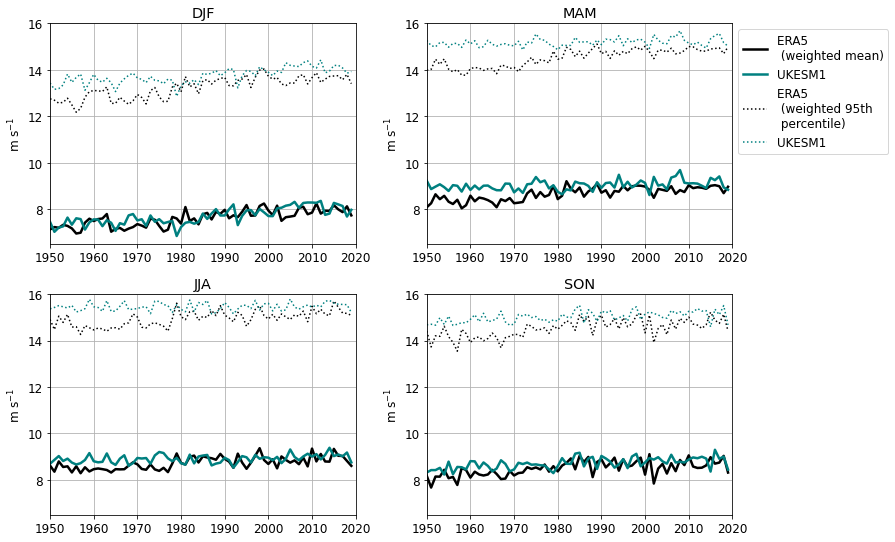

In [161]:
fact = 0.7
fig, axs = plt.subplots(2,2, figsize=(18*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

lw = 2.5
##spring
yrs = np.arange(1950,2020,1)

for i in range(0,4):
    axs[i].plot(yrs,seasmean_ts_era_s50[:,i], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
    axs[i].plot(yrs,seasmean_ts_ukesm_s50[:,i], linewidth = lw, color = 'teal', label = 'UKESM1')
    
    axs[i].plot(yrs,seas95_ts_era_s50[:,i], linewidth = lw-1, linestyle = ':', color = 'black', label = 'ERA5 \n (weighted 95th \n percentile)')
    axs[i].plot(yrs,seas95_ts_ukesm_s50[:,i], linewidth = lw-1, linestyle = ':', color = 'teal', label = 'UKESM1')
    
    # axs[i].plot(yrs,seasextrema_ts_era_s505[:,i], linewidth = lw-1, color = 'black', label = 'ERA5 \n (unweighted mean of \n values above 95th percentile)')
    # axs[i].plot(yrs,seasextrema_ts_ukesm_s50[:,i], linewidth = lw-1, color = 'teal', label = 'UKESM1')

tits  = ['DJF','MAM', 'JJA', 'SON']

for p in range(0,4):
    axs[p].grid(); axs[p].set_xlim([1950,2020])
    axs[p].set_xticks(np.arange(1950,2030,10), fontsize = 10)
    axs[p].set_ylabel('m s$^{-1}$')
    axs[p].set_ylim([6.5,16])
    axs[p].set_title(tits[p])
    
    axs[1].legend(bbox_to_anchor = [1, 1])
        
#plt.suptitle('Wind Speed Statistic comparison UKESM1 vs ERA5, \n calculated from spatiotemporal averages (ie all days and points in a given season and year, weighted by cell size) \n Southern Ocean <-30S')
plt.tight_layout()
fig.savefig('./figs/Fig_linemean_UKESM_ERA_s50.jpg')

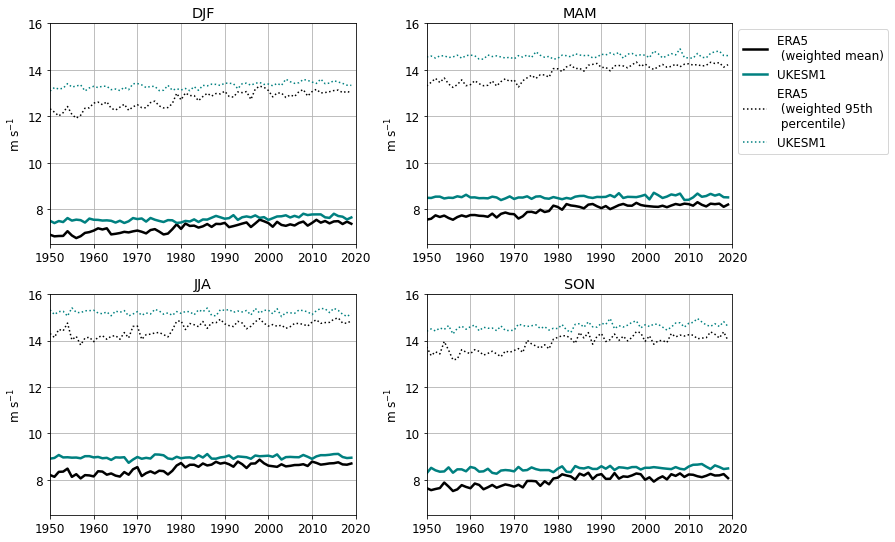

In [162]:
fact = 0.7
fig, axs = plt.subplots(2,2, figsize=(18*fact, 11*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

lw = 2.5
##spring
yrs = np.arange(1950,2020,1)

for i in range(0,4):
    axs[i].plot(yrs,seasmean_ts_era5[:,i], linewidth = lw, color = 'black', label = 'ERA5 \n (weighted mean)')
    axs[i].plot(yrs,seasmean_ts_ukesm[:,i], linewidth = lw, color = 'teal', label = 'UKESM1')
    
    axs[i].plot(yrs,seas95_ts_era5[:,i], linewidth = lw-1, linestyle = ':', color = 'black', label = 'ERA5 \n (weighted 95th \n percentile)')
    axs[i].plot(yrs,seas95_ts_ukesm[:,i], linewidth = lw-1, linestyle = ':', color = 'teal', label = 'UKESM1')
    
    # axs[i].plot(yrs,seasextrema_ts_era5[:,i], linewidth = lw-1, color = 'black', label = 'ERA5 \n (unweighted mean of \n values above 95th percentile)')
    # axs[i].plot(yrs,seasextrema_ts_ukesm[:,i], linewidth = lw-1, color = 'teal', label = 'UKESM1')

tits  = ['DJF','MAM', 'JJA', 'SON']

for p in range(0,4):
    axs[p].grid(); axs[p].set_xlim([1950,2020])
    axs[p].set_xticks(np.arange(1950,2030,10), fontsize = 10)
    axs[p].set_ylabel('m s$^{-1}$')
    axs[p].set_ylim([6.5,16])
    axs[p].set_title(tits[p])
    
    axs[1].legend(bbox_to_anchor = [1, 1])
        
#plt.suptitle('Wind Speed Statistic comparison UKESM1 vs ERA5, \n calculated from spatiotemporal averages (ie all days and points in a given season and year, weighted by cell size) \n Southern Ocean <-30S')
plt.tight_layout()
plt.tight_layout()
fig.savefig('./figs/Fig_linemean_UKESM_ERA_s30.jpg')


In [163]:
np.shape(seasmean_map_ts_ukesm)

(70, 4, 50, 182)

In [164]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, northex = -50, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    # lons = nav_lon[0:50,:]; lats = nav_lat[0:50,:]; 
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = 10)
        cb.set_ticks(tticks, fontsize = 105)
        cb.ax.tick_params(labelsize=10)
    return cb

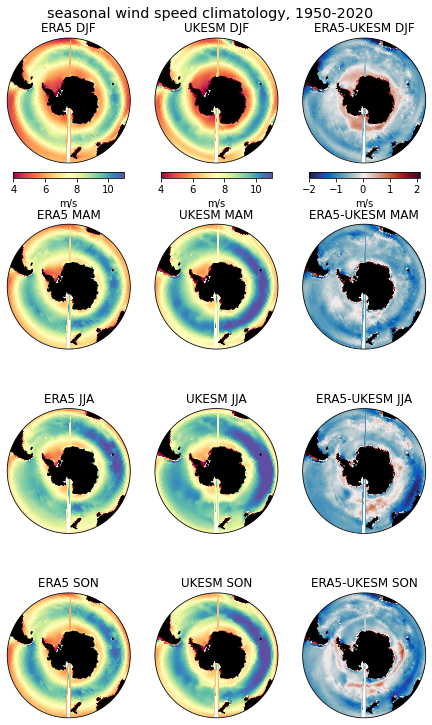

In [165]:
basin = nc.Dataset('/gpfs/data/greenocean/software/resources/ModelResources/BasinMasks/clq_basin_masks_ORCA.nc')
nav_lat = basin['Y'][:]
nav_lon = basin['X'][:]
lons = nav_lon[0:50,:]
lats = nav_lat[0:50,:]

spbot = 4; sptop = 11; spint = 2
difbot = -2; diftop = 2.1; difint = 1
tcm = 'Spectral'


fact = 0.25
fig = plt.figure(figsize=[30*fact, 52*fact])


tits = ['ERA5 DJF', 'UKESM DJF', 'ERA5-UKESM DJF','ERA5 MAM', 'UKESM MAM', 'ERA5-UKESM MAM',\
        'ERA5 JJA', 'UKESM JJA', 'ERA5-UKESM JJA','ERA5 SON', 'UKESM SON', 'ERA5-UKESM SON']
toplot = [np.nanmean(seasmean_map_ts_era5[:,0,:,:], axis = 0), np.nanmean(seasmean_map_ts_ukesm[:,0,:,:], axis = 0), \
         np.nanmean(seasmean_map_ts_era5[:,0,:,:], axis = 0)- np.nanmean(seasmean_map_ts_ukesm[:,0,:,:], axis = 0),
          np.nanmean(seasmean_map_ts_era5[:,1,:,:], axis = 0), np.nanmean(seasmean_map_ts_ukesm[:,1,:,:], axis = 0), \
         np.nanmean(seasmean_map_ts_era5[:,1,:,:], axis = 0)- np.nanmean(seasmean_map_ts_ukesm[:,1,:,:], axis = 0),
          np.nanmean(seasmean_map_ts_era5[:,2,:,:], axis = 0), np.nanmean(seasmean_map_ts_ukesm[:,2,:,:], axis = 0), \
         np.nanmean(seasmean_map_ts_era5[:,2,:,:], axis = 0)- np.nanmean(seasmean_map_ts_ukesm[:,2,:,:], axis = 0),
          np.nanmean(seasmean_map_ts_era5[:,3,:,:], axis = 0), np.nanmean(seasmean_map_ts_ukesm[:,3,:,:], axis = 0), \
         np.nanmean(seasmean_map_ts_era5[:,3,:,:], axis = 0)- np.nanmean(seasmean_map_ts_ukesm[:,3,:,:], axis = 0)]
        
cms = [tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance]
bb = [spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop]
intvl = [spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint]
#test = seasmean_map_ts_ukesm[0,0,:,:]


for i in range(0,12):
    test = toplot[i]
    botbound = bb[i]
    topbound = tb[i]
    tint = intvl[i]
    if i < 3:
        tcbr = True
    else:
        tcbr = False
    ax1 = fig.add_subplot(4, 3, i+1, projection=ccrs.Orthographic(0, -90))
    bc = plot_southern(tfig, ax1, lons, lats, test, botbound, 
                  topbound, np.arange(botbound,topbound,tint), northex = -50, fs = 12, 
                  tit = tits[i], cbarlab = 'm/s', tcmap = cms[i], lm = True, cbr = tcbr)
    
plt.suptitle('seasonal wind speed climatology, 1950-2020', y = 0.90)
plt.tight_layout()
fig.savefig('./figs/Fig_climatologymap_UKESM_ERA.jpg')


In [166]:
era5_1955 = np.nanmean(seasmean_map_ts_era5[0:10,:,:,:], axis = 0)
era5_2015 = np.nanmean(seasmean_map_ts_era5[60:70,:,:,:], axis = 0)
era5_6dec = era5_2015-era5_1955
ukesm_1955 = np.nanmean(seasmean_map_ts_ukesm[0:10,:,:,:], axis = 0)
ukesm_2015 = np.nanmean(seasmean_map_ts_ukesm[60:70,:,:,:], axis = 0)
ukesm_6dec = ukesm_2015-ukesm_1955


# the decadal seasonal wind speed increases are calculated by averaging [1950-1960] and [2010-2020], subtracting the 1950s from the 2010s, and dividing by 6. 

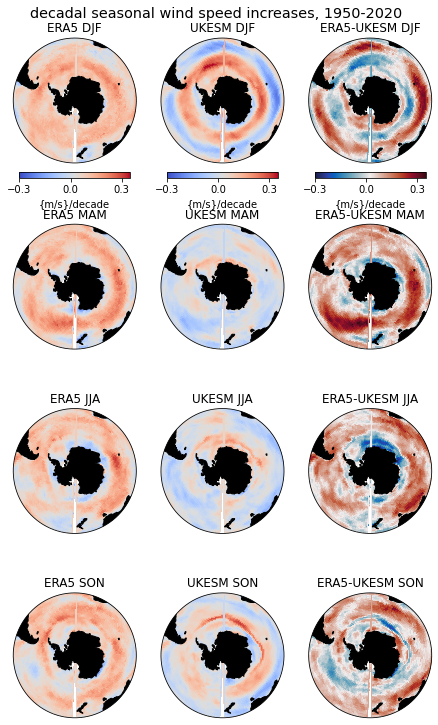

In [167]:
basin = nc.Dataset('/gpfs/data/greenocean/software/resources/ModelResources/BasinMasks/clq_basin_masks_ORCA.nc')
nav_lat = basin['Y'][:]
nav_lon = basin['X'][:]
# lons = nav_lon[0:37,:]
# lats = nav_lat[0:37,:]

spbot = -0.3; sptop = 0.35; spint = 0.3
difbot = -0.3; diftop = 0.35; difint = 0.3
tcm = 'coolwarm'


fact = 0.25
fig = plt.figure(figsize=[30*fact, 52*fact])


tits = ['ERA5 DJF', 'UKESM DJF', 'ERA5-UKESM DJF','ERA5 MAM', 'UKESM MAM', 'ERA5-UKESM MAM',\
        'ERA5 JJA', 'UKESM JJA', 'ERA5-UKESM JJA','ERA5 SON', 'UKESM SON', 'ERA5-UKESM SON']
toplot = [era5_6dec[0,:,:],ukesm_6dec[0,:,:],era5_6dec[0,:,:]-ukesm_6dec[0,:,:],
         era5_6dec[1,:,:],ukesm_6dec[1,:,:],era5_6dec[1,:,:]-ukesm_6dec[1,:,:],
         era5_6dec[2,:,:],ukesm_6dec[2,:,:],era5_6dec[2,:,:]-ukesm_6dec[2,:,:],
         era5_6dec[3,:,:],ukesm_6dec[3,:,:],era5_6dec[3,:,:]-ukesm_6dec[3,:,:]]
        
cms = [tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance, tcm, tcm, cm.balance]
bb = [spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot,spbot, spbot, difbot]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop]
tb = [sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop,sptop, sptop, diftop]
intvl = [spint, spint, difint,spint, spint, difint,spint, spint, difint,spint, spint, difint]
#test = seasmean_map_ts_ukesm[0,0,:,:]


for i in range(0,12):
    test = toplot[i]
    botbound = bb[i]
    topbound = tb[i]
    tint = intvl[i]
    if i < 3:
        tcbr = True
    else:
        tcbr = False
    ax1 = fig.add_subplot(4, 3, i+1, projection=ccrs.Orthographic(0, -90))
    bc = plot_southern(tfig, ax1, lons, lats, test/6, botbound, 
                  topbound, np.arange(botbound,topbound,tint), northex = -50, fs = 12, 
                  tit = tits[i], cbarlab = '{m/s}/decade', tcmap = cms[i], lm = True, cbr = tcbr)
    
plt.suptitle('decadal seasonal wind speed increases, 1950-2020', y = 0.90)
plt.tight_layout()
fig.savefig('./figs/Fig_decadalincreases_UKESM_ERA.jpg')

### hovmoller

In [168]:
def make_yearlist_ukesm():
    yrst = 1950
    yrend = 2014
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'/gpfs/data/greenocean/software/resources/winds_gooddates/UKESM_scen_1H_wspd*{yrs[i]}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ylist_ukesm = make_yearlist_ukesm()
ukesm_wind = xr.open_mfdataset(ylist_ukesm)

def make_yearlist_era5():
    yrst = 1950
    yrend = 2014
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        if ((yrs[i]>=1959) & (yrs[i]<1980)):
            ty = f'/gpfs/data/greenocean/software/resources/winds_gooddates/ERA5_v202303_wspd*{yrs[i]}*.nc'
        else:
            ty = f'/gpfs/data/greenocean/software/resources/winds_gooddates/ERA5_v2022_wspd*{yrs[i]}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ylist_ukesm = make_yearlist_ukesm()
ukesm_wind = xr.open_mfdataset(ylist_ukesm)
ylist_era5 = make_yearlist_era5()
era5_wind = xr.open_mfdataset(ylist_era5)

In [169]:
hovmol_ukesm = ukesm_wind.isel(y = slice(0,50)).weighted(tmesh['csize'].isel(y = slice(0,50))).mean(dim = ['x'])
hovmol_era5 = era5_wind.isel(y = slice(0,50)).weighted(tmesh['csize'].isel(y = slice(0,50))).mean(dim = ['x'])

In [170]:
lats = nav_lat[0:50,80]

tind = [7, 15, 22, 27,32,36,40,43,46,49]
tind = np.array([7,  22, 32,40,46])
tind_lat = np.zeros_like(tind)
for i in range(0,len(tind)):
    tind_lat[i] = np.round(lats[tind[i]])
print(tind_lat)

[-75 -65 -55 -45 -35]


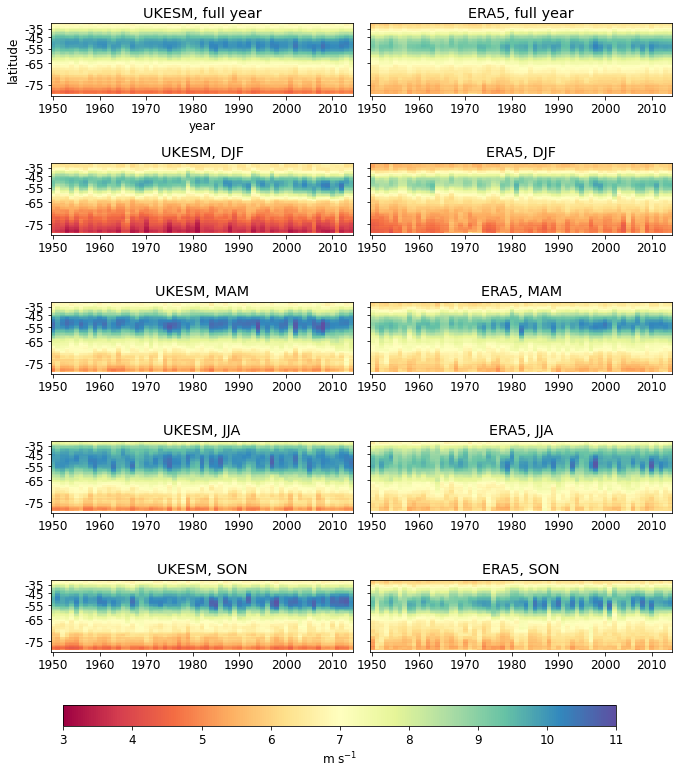

In [171]:
tvmin = 3; tvmax = 11

fact = 0.8
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()

ind = 0
test = hovmol_ukesm.wspd.groupby('time_counter.year').mean().T
w = xr.plot.pcolormesh(test, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')


ind = 1
test = hovmol_era5.wspd.groupby('time_counter.year').mean().T
w = xr.plot.pcolormesh(test, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')
test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
xr.plot.pcolormesh(test, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = 'Spectral')

axs[0].set_yticks(tind)
axs[0].set_yticklabels(tind_lat)
axs[0].set_ylabel('latitude')

axs[0].set_title('UKESM, full year')
axs[2].set_title('UKESM, DJF')
axs[4].set_title('UKESM, MAM')
axs[6].set_title('UKESM, JJA')
axs[8].set_title('UKESM, SON')


axs[0+ind].set_title('ERA5, full year')
axs[2+ind].set_title('ERA5, DJF')
axs[4+ind].set_title('ERA5, MAM')
axs[6+ind].set_title('ERA5, JJA')
axs[8+ind].set_title('ERA5, SON')

for i in range(1,10):
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

axs[0].set_yticks(tind)
axs[0].set_yticklabels(tind_lat)
axs[0].set_ylabel('latitude')    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
plt.tight_layout()
plt.show()
fig.savefig('./figs/Fig-hovmoller-raw.jpg')

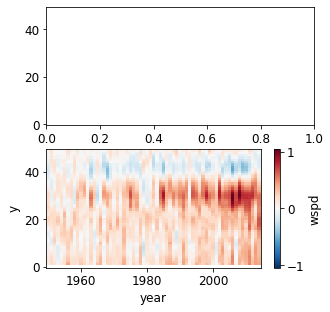

In [194]:
fact = 0.4
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()

test = hovmol_ukesm.wspd.groupby('time_counter.year').mean().T
test_1960 = hovmol_ukesm.wspd.sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
test_inc = test - test_1960
test_inc

w = xr.plot.pcolormesh(test_inc)

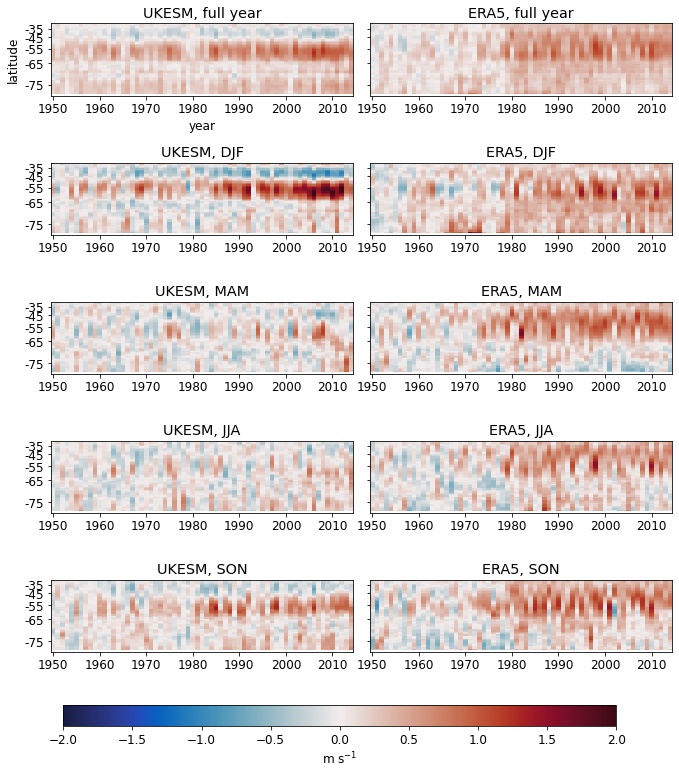

In [197]:
tvmin = -2; tvmax = 2
tcm = cm.balance

fact = 0.8
fig, axs = plt.subplots(5,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k', sharey= True)
axs = axs.ravel()

ind = 0
test = hovmol_ukesm.wspd.groupby('time_counter.year').mean().T
test_1960 = hovmol_ukesm.wspd.sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
w = xr.plot.pcolormesh(test - test_1960, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
test_1960 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'DJF')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
test_1960 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'MAM')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
test_1960 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'JJA')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
test_1960 = hovmol_ukesm.wspd.sel(time_counter=(hovmol_ukesm['time_counter.season'] == 'SON')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)
#########
ind = 1
test = hovmol_era5.wspd.groupby('time_counter.year').mean().T
test_1960 = hovmol_era5.wspd.sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
w = xr.plot.pcolormesh(test - test_1960, ax = axs[0+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).groupby('time_counter.year').mean().T
test_1960 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'DJF')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[2+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).groupby('time_counter.year').mean().T
test_1960 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'MAM')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[4+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).groupby('time_counter.year').mean().T
test_1960 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'JJA')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[6+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)

test = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).groupby('time_counter.year').mean().T
test_1960 = hovmol_era5.wspd.sel(time_counter=(hovmol_era5['time_counter.season'] == 'SON')).sel(time_counter =slice("1950-01-01", "1960-01-02")).\
groupby('time_counter.year').mean().mean(dim = 'year').T
xr.plot.pcolormesh(test - test_1960, ax = axs[8+ind], add_colorbar=False, vmin = tvmin, vmax = tvmax, cmap = tcm)


axs[0].set_yticks(tind)
axs[0].set_yticklabels(tind_lat)
axs[0].set_ylabel('latitude')

axs[0].set_title('UKESM, full year')
axs[2].set_title('UKESM, DJF')
axs[4].set_title('UKESM, MAM')
axs[6].set_title('UKESM, JJA')
axs[8].set_title('UKESM, SON')

ind = 1
axs[0+ind].set_title('ERA5, full year')
axs[2+ind].set_title('ERA5, DJF')
axs[4+ind].set_title('ERA5, MAM')
axs[6+ind].set_title('ERA5, JJA')
axs[8+ind].set_title('ERA5, SON')

for i in range(1,10):
    axs[i].set_yticks([])
    axs[i].set_yticklabels([])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')

axs[0].set_yticks(tind)
axs[0].set_yticklabels(tind_lat)
axs[0].set_ylabel('latitude')    
    
cbar_ax = fig.add_axes([0.1, -0.06, .8, .03]) #left, bottom, width, height
fig.colorbar(w, cax=cbar_ax, orientation="horizontal", label = 'm s$^{-1}$')
plt.tight_layout()
plt.show()
fig.savefig('./figs/Fig-hovmoller-diffraw.jpg')